In [1]:
# First, let's load our experimental cloud point data; we're using PaDEL-Descriptor to generate QSPR descriptors

from ecnet.datasets import load_cp

dataset = load_cp(as_dataset=True, backend='padel')

print(f'Number of samples: {dataset.desc_vals.shape[0]}')
print(f'Number of QSPR descriptors per sample: {dataset.desc_vals.shape[1]}')

Number of samples: 43
Number of QSPR descriptors per sample: 1875


In [2]:
# Now we create training and testing data subsets; our ANNs regress directly on the training data, and the test set is used to measure blind prediction accuracy

from sklearn.model_selection import train_test_split
from copy import deepcopy

index_train, index_test = train_test_split([i for i in range(len(dataset))], test_size=0.2, random_state=24)

dataset_train = deepcopy(dataset)
dataset_train.set_index(index_train)

dataset_test = deepcopy(dataset)
dataset_test.set_index(index_test)

print(f'Number of samples in the training set: {len(dataset_train)}')
print(f'Number of samples in the testing set: {len(dataset_test)}')

Number of samples in the training set: 34
Number of samples in the testing set: 9


<Figure size 432x288 with 0 Axes>

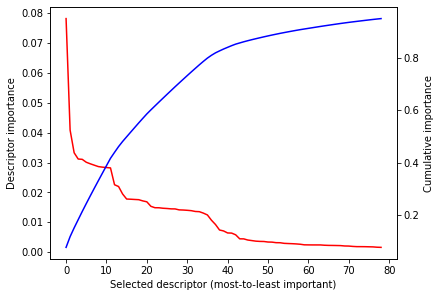

In [3]:
# Many QSPR descriptors are not important when predicting cloud point for a database of hydrocarbons and oxygenated compounds; for example, the descriptor counting the number of nitrogen atoms will be zero for all compounds. We will select the descriptors with the highest correlation to cloud point for use as ANN inputs, such that 95% of total correlation (derived from random forest regression) is retained:

from ecnet.tasks.feature_selection import select_rfr
from matplotlib import pyplot as plt

# Note: we select based on the training set, we want the test set to be 100% blind
desc_idx, desc_imp = select_rfr(dataset_train, total_importance=0.95, n_estimators=50)

dataset_train.set_desc_index(desc_idx)
dataset_test.set_desc_index(desc_idx)

# Let's graph importance (individual and cumulative sum) for the selected descriptors:
rank = [i for i in range(len(desc_imp))]
tot_imp = [0.0]
for imp in desc_imp:
    tot_imp.append(tot_imp[-1] + imp)
tot_imp = tot_imp[1:]

plt.clf()
fig, ax = plt.subplots(constrained_layout=True)
ax.set_xlabel('Selected descriptor (most-to-least important)')
ax.set_ylabel('Descriptor importance')
ax.plot(rank, desc_imp, color='red')
ax2 = ax.twinx()
ax2.set_ylabel('Cumulative importance')
ax2.plot(rank, tot_imp, color='blue')
plt.show()

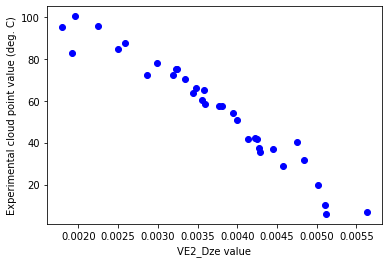

In [4]:
# We observe that there are only a handful of QSPR descriptors with significant correlation to cloud point; let's visualize the relationship between kinematic viscosity and the descriptor with the highest importance:

ysi = [dataset_train.target_vals[i][0] for i in range(len(dataset_train))]
top_desc = [dataset_train.desc_vals[i][0] for i in range(len(dataset_train))]

plt.clf()
plt.xlabel(f'{dataset_train.desc_names[0]} value')
plt.ylabel('Experimental cloud point value (deg. C)')
plt.scatter(top_desc, ysi, color='blue')
plt.show()

In [5]:
# Enough exploration, let's train an ANN to predict kinematic viscosity:

from ecnet import ECNet

# Create an ANN with `n` input neurons (where `n` == number of selected QSPR descriptors), 2 hidden layers with 256 neurons each, and one output neuron (corresponding to yield sooting index)
model = ECNet(dataset_train.desc_vals.shape[1], 1, 256, 2)
# arguments follow [input dim, output dim, hidden dim, n hidden]

# Train the ANN using training dataset, with a random 20% of the dataset used for validation every epoch:
train_loss, valid_loss = model.fit(
    dataset=dataset_train, valid_size=0.2, verbose=10,
    patience=32, epochs=300, random_state=None, shuffle=True,
    lr=0.005
)

Epoch: 0 | Train loss: 3019.848388671875 | Valid loss: 9223372036854775807
Epoch: 10 | Train loss: 301.50048828125 | Valid loss: 571.7460327148438
Epoch: 20 | Train loss: 351.8019104003906 | Valid loss: 800.0086669921875
Epoch: 30 | Train loss: 330.5296325683594 | Valid loss: 539.5159301757812
Epoch: 40 | Train loss: 264.02142333984375 | Valid loss: 315.75274658203125
Epoch: 50 | Train loss: 198.6739501953125 | Valid loss: 249.75222778320312
Epoch: 60 | Train loss: 87.38817596435547 | Valid loss: 125.52989196777344
Epoch: 70 | Train loss: 59.61891555786133 | Valid loss: 100.54280090332031
Epoch: 80 | Train loss: 43.34950256347656 | Valid loss: 78.16502380371094
Epoch: 90 | Train loss: 60.24040985107422 | Valid loss: 91.14484405517578


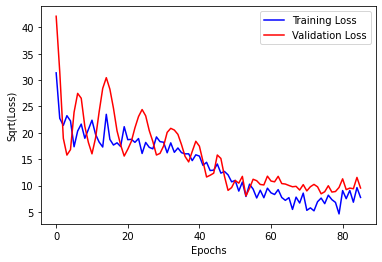

In [6]:
# We can visualize the training set's loss over training, as well as the validation subset's loss:

from math import sqrt

train_loss = [sqrt(l) for l in train_loss][5:]
valid_loss = [sqrt(l) for l in valid_loss][5:]
epoch = [i for i in range(len(train_loss))]
plt.clf()
plt.xlabel('Epochs')
plt.ylabel('Sqrt(Loss)')
plt.plot(epoch, train_loss, color='blue', label='Training Loss')
plt.plot(epoch, valid_loss, color='red', label='Validation Loss')
plt.legend(loc='upper right')
plt.show()

In [7]:
# Let's calculate median absolute error and r-squared coefficient for each dataset:

from sklearn.metrics import median_absolute_error, r2_score

y_hat_train = model(dataset_train.desc_vals).detach().numpy()
y_train = dataset_train.target_vals
train_mae = median_absolute_error(y_hat_train, y_train)
train_r2 = r2_score(y_hat_train, y_train)
y_hat_test = model(dataset_test.desc_vals).detach().numpy()
y_test = dataset_test.target_vals
test_mae = median_absolute_error(y_hat_test, y_test)
test_r2 = r2_score(y_hat_test, y_test)
print(f'Training median absolute error: {train_mae}')
print(f'Training r-squared coefficient: {train_r2}')
print(f'Testing median absolute error: {test_mae}')
print(f'Testing r-squared coefficient: {test_r2}')

Training median absolute error: 4.776594161987305
Training r-squared coefficient: 0.8675852185693186
Testing median absolute error: 9.086380004882812
Testing r-squared coefficient: 0.8877325994065388


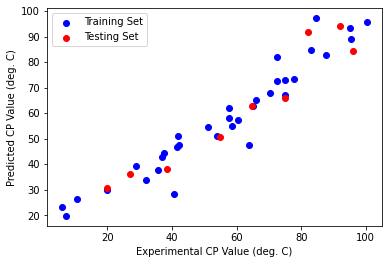

In [8]:
# Now we can visually compare predicted values to experimental values:

plt.clf()
plt.xlabel('Experimental CP Value (deg. C)')
plt.ylabel('Predicted CP Value (deg. C)')
plt.scatter(y_train, y_hat_train, color='blue', label='Training Set')
plt.scatter(y_test, y_hat_test, color='red', label='Testing Set')
plt.legend(loc='upper left')
plt.show()

In [9]:
# Let's save our model for later use:

model.save('cp_model.pt')

Training median absolute error: 4.776594161987305
Training r-squared coefficient: 0.8675852185693186
Testing median absolute error: 9.086380004882812
Testing r-squared coefficient: 0.8877325994065388


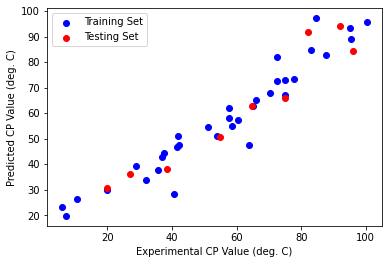

In [10]:
# And test to make sure we can recall it:

from ecnet.model import load_model

model_2 = load_model('cp_model.pt')

y_hat_train = model_2(dataset_train.desc_vals).detach().numpy()
y_train = dataset_train.target_vals
train_mae = median_absolute_error(y_hat_train, y_train)
train_r2 = r2_score(y_hat_train, y_train)
y_hat_test = model_2(dataset_test.desc_vals).detach().numpy()
y_test = dataset_test.target_vals
test_mae = median_absolute_error(y_hat_test, y_test)
test_r2 = r2_score(y_hat_test, y_test)
print(f'Training median absolute error: {train_mae}')
print(f'Training r-squared coefficient: {train_r2}')
print(f'Testing median absolute error: {test_mae}')
print(f'Testing r-squared coefficient: {test_r2}')

plt.clf()
plt.xlabel('Experimental CP Value (deg. C)')
plt.ylabel('Predicted CP Value (deg. C)')
plt.scatter(y_train, y_hat_train, color='blue', label='Training Set')
plt.scatter(y_test, y_hat_test, color='red', label='Testing Set')
plt.legend(loc='upper left')
plt.show()